In [68]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 20})

In [2]:
np.random.seed(1)
a = np.zeros((5, 100))
b = np.zeros((5, 5), dtype=int)
for i in range(5):
    b[i] = np.random.choice(np.arange(100), size=5, replace=False)
a[np.arange(5)[:, None], b] = 1  # 使用高级索引来设置a的值

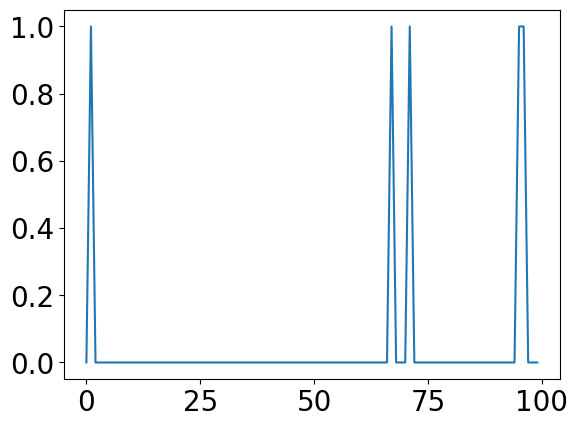

In [3]:
plt.plot(a[2], label='0')

In [4]:
import numpy as np

# 定义类别数量、数据维度和每个类别的数据数量
num_classes = 10
num_dimensions = 5
num_spikes = 5
num_data_per_class = 500
time_dur = 100

# 存储所有类别的 spike time 和 spike train 数据
all_spike_times = []
all_spike_trains = []

# 存储已经使用过的维度对
used_pairs = []

# 生成数据
for _ in range(num_classes):
    class_spike_times = []
    class_spike_trains = []
    
    # 选择尚未使用过的两个不同的维度
    while True:
        dim1, dim2 = np.random.choice(num_dimensions, 2, replace=False)
        if (dim1, dim2) not in used_pairs and (dim2, dim1) not in used_pairs:
            used_pairs.append((dim1, dim2))
            break
    
    # 生成500个数据点
    for _ in range(num_data_per_class):
        spike_train = np.zeros((num_dimensions, time_dur))
        spike_times = np.zeros((num_dimensions, num_spikes), dtype=int)
        
        # 生成随机数据
        for i in range(num_dimensions):
            spike_times[i] = np.random.choice(np.arange(time_dur), size=num_spikes, replace=False)
        
        # 将选定的两个维度的数据设为相同
        spike_times[dim2] = spike_times[dim1]
        spike_train[np.arange(num_dimensions)[:, None], spike_times] = 1
        
        class_spike_times.append(spike_times)
        class_spike_trains.append(spike_train)

    all_spike_times.append(class_spike_times)
    all_spike_trains.append(class_spike_trains)

all_spike_times = np.array(all_spike_times)
all_spike_trains = np.array(all_spike_trains)

all_spike_times = torch.tensor(all_spike_times, dtype=torch.float32)
all_spike_trains = torch.tensor(all_spike_trains, dtype=torch.float32)

In [6]:
def create_kernel(tau_rise, tau_decay, time_dur):
    T = torch.arange(time_dur)
    y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
    return y

class DBNNCorr(nn.Module):
    def __init__(self, num_dimensions, time_dur):
        super(DBNNCorr, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        # fixed time constant
        self.tau_rise = 5 
        self.tau_decay = 30 

        self.kernel = create_kernel(self.tau_rise, self.tau_decay, time_dur)
        self.kernel_flipped = torch.flip(self.kernel, dims=[0]).view(1, 1, -1)
        
        self.conv = nn.Conv1d(1, 1, kernel_size=self.time_dur, padding=self.time_dur - 1, bias=False)
        
        # Set the weights of the convolution layer
        with torch.no_grad():
            self.conv.weight = nn.Parameter(self.kernel_flipped)
        
    def forward(self, x):
        return self.conv(x).view(-1)[:time_dur]

In [7]:
kernel = create_kernel(5, 30, time_dur=time_dur)
kernel_flipped = torch.flip(kernel, dims=[0]).view(1, 1, -1)
data = torch.zeros((1, 100)).view(1, 1, -1)
data[0, 0, 0] = 1
data[0, 0, 50] = 1
b = torch.nn.functional.conv1d(data, kernel_flipped, padding=(99)).view(-1)[:100]

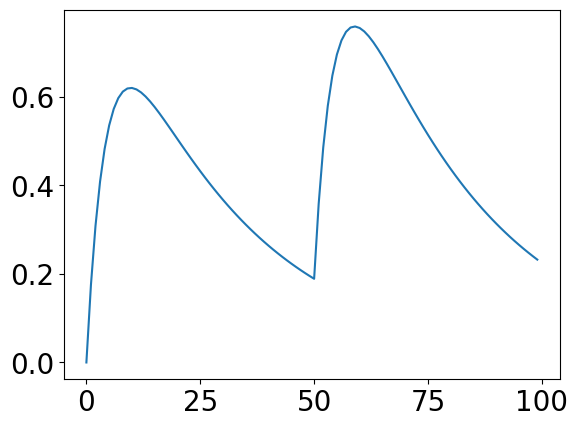

In [8]:
plt.plot(b)

In [151]:
def create_kernel(tau_rise, tau_decay, time_dur):
    T = torch.arange(time_dur)
    y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
    return y

class DBNNCorr(nn.Module):
    def __init__(self, num_dimensions, time_dur):
        super(DBNNCorr, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        # fixed time constant
        self.tau_rise = 5 
        self.tau_decay = 30 

        self.kernel = create_kernel(self.tau_rise, self.tau_decay, time_dur)
        self.kernel_flipped = torch.flip(self.kernel, dims=[0]).view(1, 1, -1)
        
        self.conv = nn.Conv1d(1, 1, kernel_size=self.time_dur, padding=self.time_dur - 1, bias=False)
        
        # Set the weights of the convolution layer
        with torch.no_grad():
            self.conv.weight = nn.Parameter(self.kernel_flipped)
        
    def forward(self, x):
        return self.conv(x).view(-1)[:100]

In [159]:
data = torch.zeros((5, 100))
data = torch.unsqueeze(data, 0)

In [160]:
data.size()

torch.Size([1, 5, 100])

In [9]:
kernel = create_kernel(5, 30, time_dur=time_dur)
kernel_flipped = torch.flip(kernel, dims=[0]).view(1, 1, -1)
kernels = kernel_flipped.repeat(5, 1, 1)

In [10]:
kernels.size()

torch.Size([5, 1, 100])

In [138]:
kernel1 = 2 * create_kernel(5, 30, time_dur=time_dur)
kernel_flipped1 = torch.flip(kernel1, dims=[0])
kernel2 = 3 * create_kernel(5, 30, time_dur=time_dur)
kernel_flipped2 = torch.flip(kernel2, dims=[0])
kernel3 = 10 * create_kernel(5, 30, time_dur=time_dur)
kernel_flipped3 = torch.flip(kernel3, dims=[0])
kernel4 = 5 * create_kernel(5, 30, time_dur=time_dur)
kernel_flipped4 = torch.flip(kernel4, dims=[0])
kernel5 = 1 * create_kernel(5, 30, time_dur=time_dur)
kernel_flipped5 = torch.flip(kernel5, dims=[0])

# 将三个 kernel_flipped 堆叠起来
kernels = torch.stack([kernel_flipped1, kernel_flipped2, kernel_flipped3, kernel_flipped4, kernel_flipped5], dim=0)
kernels = kernels.unsqueeze(1)

conv = nn.Conv1d(5, 5, kernel_size=time_dur, padding=time_dur - 1, groups=5, bias=False)
conv.weight = nn.Parameter(kernels)

data = torch.zeros((5, 100))
data[0, 0] = 1
data[1, 20] = 1
data[2, 40] = 1
data[3, 60] = 1
data[4, 80] = 1
data = torch.unsqueeze(data, 0)


y = conv(data)[:,:,:100]
y_permuted = y.permute(0, 2, 1)
m = BilinearModified(5, 5, 1)
bilinear_term = m(y_permuted, y_permuted)
linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
output = linear_term + bilinear_term

In [140]:
print(kernels.size(), data.size())

torch.Size([5, 1, 100]) torch.Size([1, 5, 100])


In [106]:
bilinear_term.size(), linear_term.size(), output.size()

(torch.Size([1, 100, 1]), torch.Size([1, 100, 1]), torch.Size([1, 100, 1]))

In [113]:
print(m.weight), print(m.bias)

Parameter containing:
tensor([[[ 0.0000, -0.0073, -0.1417,  0.1685, -0.0619],
         [ 0.3942,  0.0000, -0.2652,  0.1951, -0.4316],
         [ 0.1948, -0.3030,  0.0000,  0.2332,  0.2276],
         [ 0.2374,  0.1647,  0.3673,  0.0000,  0.2211],
         [-0.0809, -0.3319,  0.1794, -0.3121,  0.0000]]], requires_grad=True)
Parameter containing:
tensor([0.0038], requires_grad=True)


(None, None)

In [120]:
z.size()

torch.Size([100])

In [136]:
z = (0.3942-0.0073)*y[0,0]*y[0,1] + (-0.1417+0.1948)*y[0,0]*y[0,2] + (-0.2652-0.3030)*y[0,1]*y[0,2] + (0.1685+0.2374)*y[0,0]*y[0,3] + (-0.0619-0.0809)*y[0,0]*y[0,4] + (0.1951+0.1647)*y[0,1]*y[0,3] + (-0.4316-0.3319)*y[0,1]*y[0,4] + (0.2332+0.3673)*y[0,2]*y[0,3] + (0.2276+0.1794)*y[0,2]*y[0,4] + (0.2211-0.3121)*y[0,3]*y[0,4]

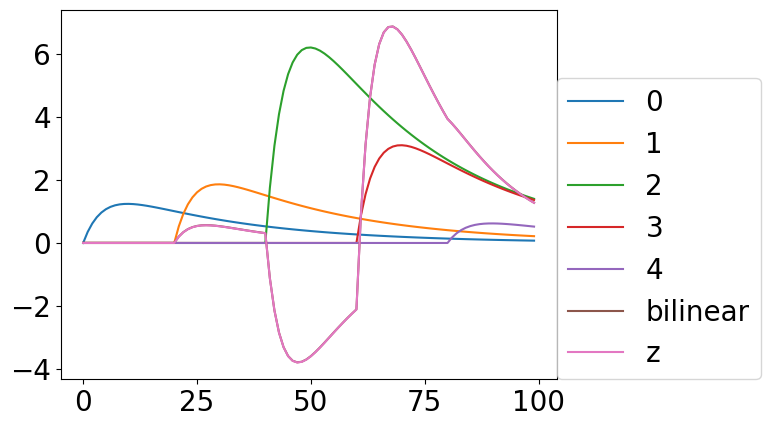

In [137]:
plt.plot(y[0 ,0].detach(), label='0')
plt.plot(y[0, 1].detach(), label='1')
plt.plot(y[0, 2].detach(), label='2')
plt.plot(y[0, 3].detach(), label='3')
plt.plot(y[0, 4].detach(), label='4')
plt.plot(bilinear_term[0].detach(), label='bilinear')
# plt.plot(linear_term[0].detach(), label='linear')
plt.plot(z.detach(), label='z')
plt.legend(loc=(1, 0))

In [84]:
print(kernels.size()),print(data.size()), print(y.size())

torch.Size([5, 1, 100])
torch.Size([1, 5, 100])
torch.Size([5, 100])


(None, None, None)

In [87]:
z = torch.sum(y, dim=2)

In [56]:
m = nn.Bilinear(3, 3, 1)
input1 = torch.ones(2, 4, 3)
input1[0, :] += 1
output = m(input1, input1)
print(output.size())

torch.Size([2, 4, 1])


In [ ]:
kappa = torch.nn.Bilinear

IndexError: index 1 is out of bounds for dimension 0 with size 1

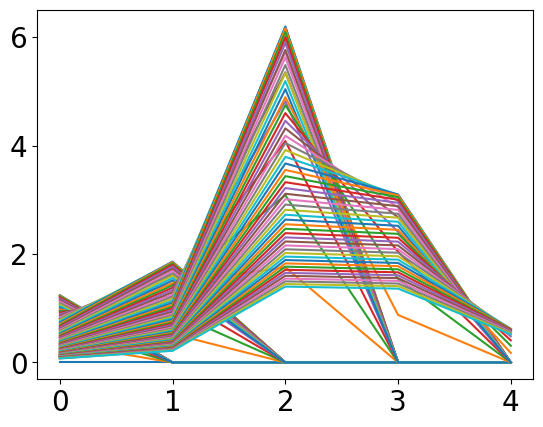

In [88]:
plt.plot(y[0].detach(), label='0')
plt.plot(y[1].detach(), label='1')
plt.plot(y[2].detach(), label='2')
plt.plot(y[3].detach(), label='3')
plt.plot(y[4].detach(), label='4')
plt.plot(z.detach(), label='sum')
plt.legend()

In [20]:
net = DBNNCorr(5, 100)
data = torch.zeros((5, 100))
data = torch.unsqueeze(data, 0)
data[0, 0, 0] = 1
data[0, 0, 50] = 1

y = net(data)
print(y.size())

RuntimeError: Given groups=1, weight of size [1, 1, 100], expected input[1, 5, 100] to have 1 channels, but got 5 channels instead

In [19]:
data.size()

torch.Size([1, 1, 500])

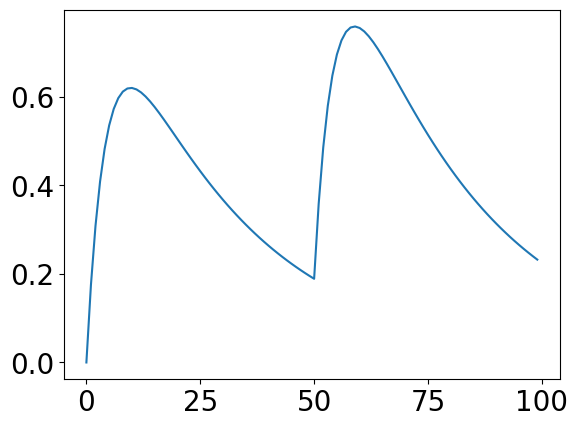

In [14]:
plt.plot(y.detach().numpy())

In [48]:
data[i].view(1, 1, -1).size()

torch.Size([1, 1, 25])

In [47]:
outputs = []
time_dur = 100
kernels = [create_kernel(5, 30, time_dur) for i in range(5)]
for data in all_data:
    convolved = torch.zeros(time_dur)
    for i in range(5):
        kernel = kernels[i].view(1, 1, -1)  # 将kernel转换为适合卷积操作的形状
        data_dim = data[i].view(1, 1, -1)   # 将data的一个维度转换为适合卷积操作的形状
        convolved += torch.nn.functional.conv1d(data_dim, kernel, padding='same').view(-1)
    outputs.append(convolved)

/tmp/ipykernel_3954730/701772276.py:9: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /croot/pytorch_1681837265408/work/aten/src/ATen/native/Convolution.cpp:895.)
  convolved += torch.nn.functional.conv1d(data_dim, kernel, padding='same').view(-1)


RuntimeError: The size of tensor a (100) must match the size of tensor b (25) at non-singleton dimension 0

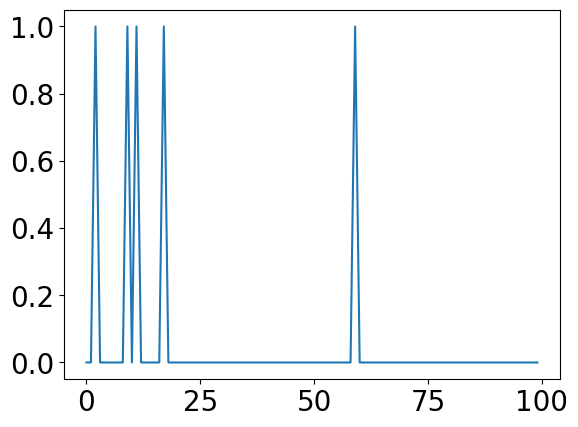

In [82]:
plt.plot(all_spike_trains[0, 2, 4], label='0')

Text(0.5, 1.0, 'pattern 1')

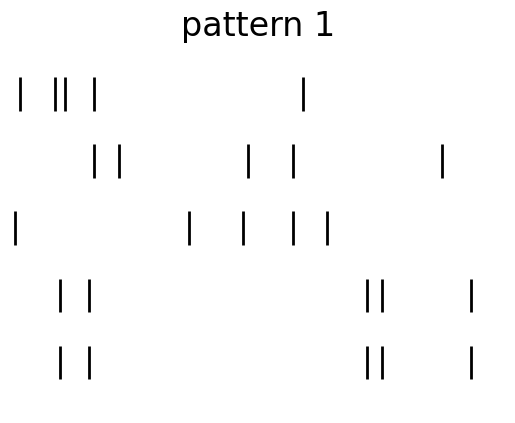

In [80]:
plt.eventplot(all_spike_times[0][2], colors='black', linelengths=0.5, linewidths=2)
plt.axis('off')
plt.xlim(0,100)
plt.title('pattern 1')
# plt.savefig('figure/raster_3.png', dpi=800)

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math

class BilinearModified(nn.Module):
    __constants__ = ['in1_features', 'in2_features', 'out_features']
    in1_features: int
    in2_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in1_features: int, in2_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in1_features, in2_features), **factory_kwargs))

        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -bound, bound)
        
        # Zero out the diagonal elements of the weight matrix
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        # Ensure diagonal elements are zero during the forward pass as well
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0
                
        return F.bilinear(input1, input2, self.weight, self.bias)

    def extra_repr(self) -> str:
        return (f'in1_features={self.in1_features}, in2_features={self.in2_features}, '
                f'out_features={self.out_features}, bias={self.bias is not None}')




torch.Size([2, 4, 1])


In [81]:
# Example usage
m = BilinearModified(3, 3, 1)
input1 = torch.ones(2, 10, 3)
input1[0, :] += 1
output = m(input1, input1)
print(output.size())  # Should output torch.Size([2, 4, 1])

torch.Size([2, 10, 1])


In [80]:
m.weight.sum() * 4 + m.bias  # Should output tensor(0.)

tensor([2.5233], grad_fn=<AddBackward0>)

In [83]:
print(m.weight), print(input1), print(output.size())

Parameter containing:
tensor([[[ 0.0000,  0.2482,  0.0302],
         [ 0.3976,  0.0000,  0.5231],
         [-0.4805,  0.1001,  0.0000]]], requires_grad=True)
tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
torch.Size([2, 10, 1])


(None, None, None)

In [ ]:
class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        # Trainable parameters
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions) * 5)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions) * 20)
        self.omega = nn.Parameter(torch.ones(num_dimensions))

        # Initialize the convolution layer (weights will be updated in forward)
        self.conv = nn.Conv1d(self.num_dimensions, self.num_dimensions, kernel_size=self.time_dur, padding=self.time_dur - 1, groups=self.num_dimensions, bias=False)

        # Initialize Bilinear layer
        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1)

    def create_kernels(self):
        T = torch.arange(self.time_dur, dtype=torch.float32)  # Ensure the correct dtype
        N = self.num_dimensions
        tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        omega = self.omega.unsqueeze(1)  # (N, 1)

        y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)  # (N, T)
        y = y * omega  # Apply weight omega
        y = y.unsqueeze(1)  # (N, 1, T)
        return y
        
    def forward(self, x):
        # Calculate kernels
        kernel = self.create_kernels()
        kernel_flipped = torch.flip(kernel, dims=[2])  # Flip along time dimension

        # Convolve using the kernel (perform manual convolution)
        y = torch.nn.functional.conv1d(x, kernel_flipped.squeeze(1), groups=self.num_dimensions, padding=self.time_dur - 1)
        
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)eeze(1)  # (N, 1)
        tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        omega = self.omega.unsqueeze(1)  # (N, 1)

        y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)  # (N, T)
        y = y * omega  # Apply weight omega
        y = y.unsqueeze(1)  # (N, 1, T)
        return y
        
    def forward(self, x):
        # Update the kernel based on trainable tau_rise, tau_decay, and omega
        kernel = self.create_kernels()
        kernel_flipped = torch.flip(kernel, dims=[1]).unsqueeze(1)
        
        # Update the convolution layer weights
        self.conv.weight.copy_(kernel_flipped.squeeze(1).transpose(0, 1))  # Use copy_ to avoid breaking the computation graph

        y = self.conv(x)[:, :, :self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)
